<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/10_time_series_forecasting_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with tensorflow + Milestone Project 3: BitPredict

Project to predict tomorrow's BTC price based on historical data

## Get data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-11-15 15:49:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2023-11-15 15:49:13 (5.26 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with Pandas

In [2]:
# Import with pandas
import pandas as pd
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"], # treat the "Date" column as dates
                 index_col=["Date"]) # index by the date column
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# How many samples
len(df)

2787

2787 samples is not much in case of a deep learning model

In [5]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df.rename(columns={"Closing Price (USD)": "Price"})["Price"]) # Doing it the same way Daniel did produces an error. .rename() method needs to be called on a DataFrame and not Series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


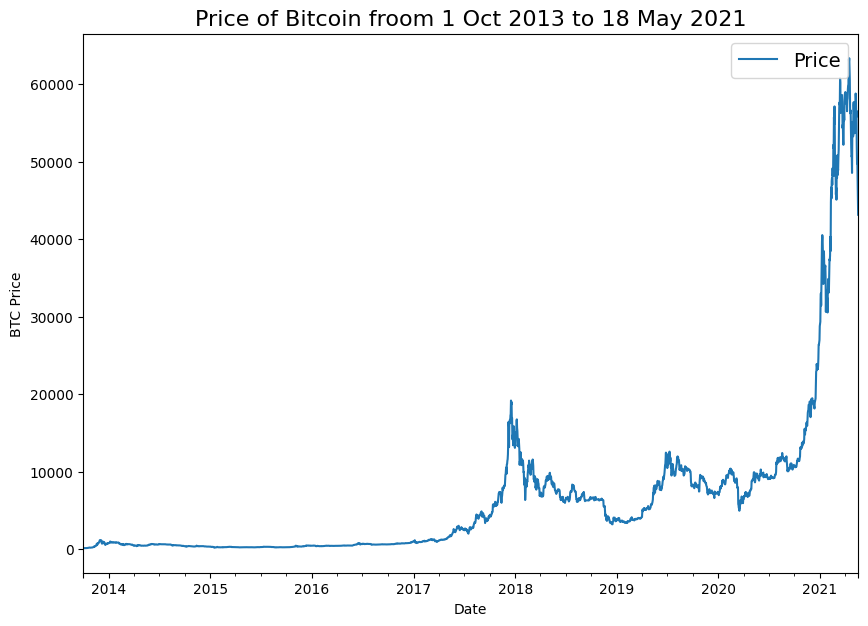

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin froom 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series with CSV module instead of Pandas

When not using Pandas

In [7]:
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip 1st line (gets rid of column names)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1],  "%Y-%m-%d")) # get the date from the line as date not string
    btc_price.append(float(line[2])) # get the price as float

# View 1st 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

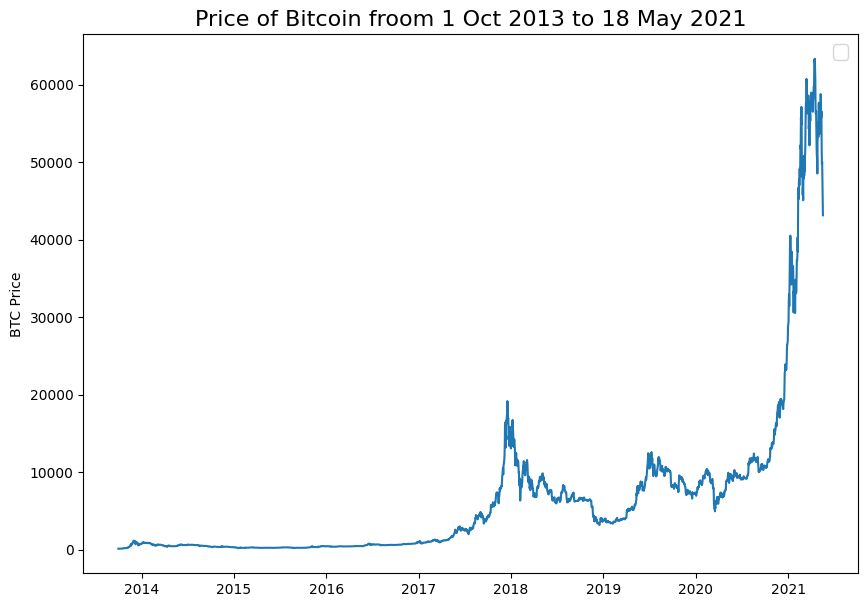

In [8]:
# Plot from CSV
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin froom 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Format data part 1: Create train and test split

### Creating train and test data the wrong way (data leakage)

In [9]:
# Get the date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

In [10]:
# Wrong way to make train/test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=.2, random_state=42)

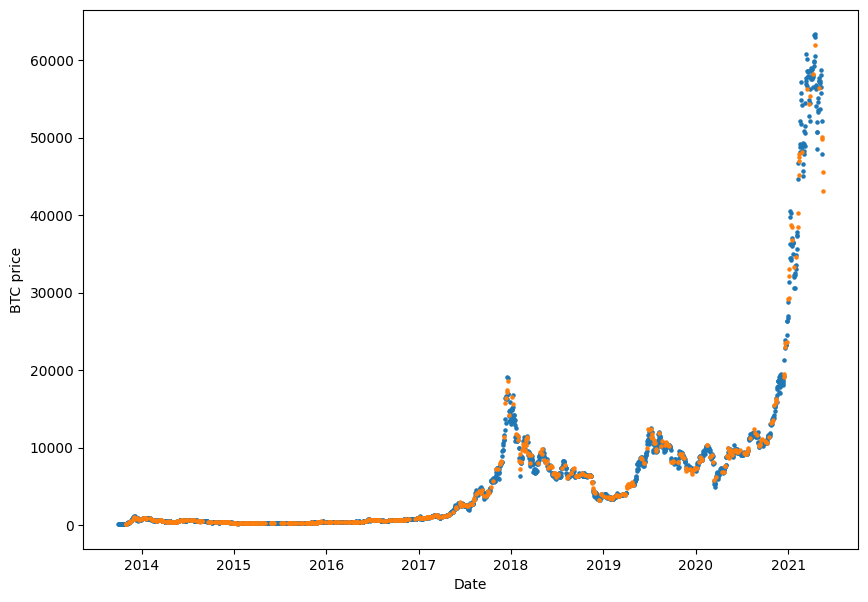

In [11]:
# Plot wrong splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC price")
plt.show();

### Create train and test split the right way

In [12]:
# Create train and test splits
split_size = int(0.8*len(prices)) # 80% train, 20% test

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]
# Create test data split
X_test, y_test = timesteps[split_size:], prices[split_size:]

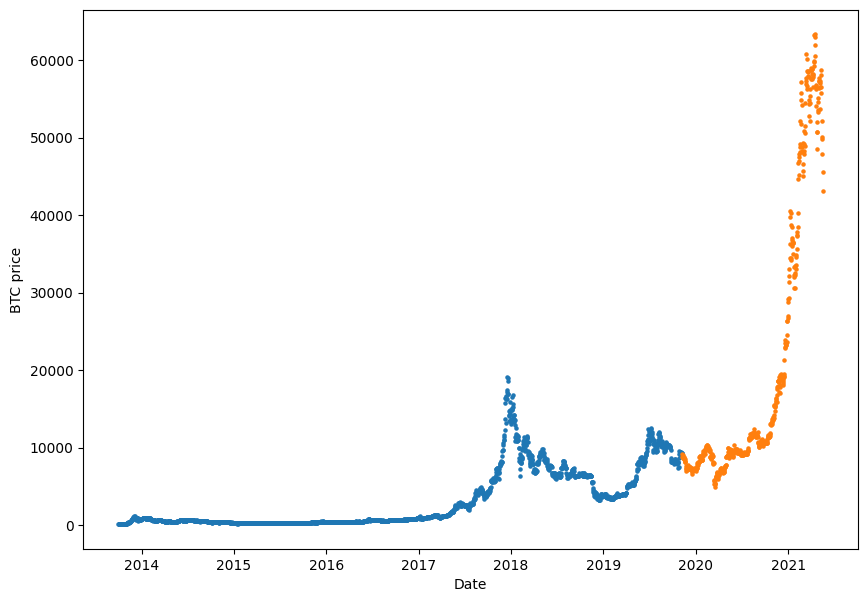

In [13]:
# Plot
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC price")
plt.show();

## Create plotting function

In [14]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps against values
  """
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

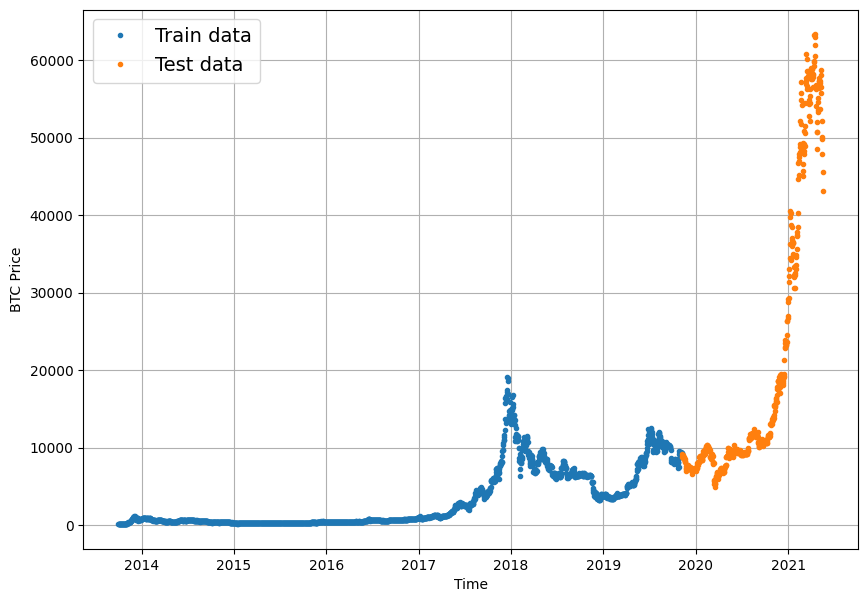

In [15]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

## Modelling

Terms:
* Horizon - number of timesteps into the future we're going to project
* Window size - number of timesteps to be used when predicting the horizon

Experiments:
0. Naive model (baseline)
1. Dense model, horizon = 1, window = 7
2. Dense model, horizon = 1, window = 30
3. Dense modesl, horizon = 7, window = 30
4. Conv1D
5. LSTM
6. Dense with multivariate data
7. N-BEATs Algorithm
8. Ensemble - multiple models optimized on different loss functions
9. Future prediction model
10. Dense with turkey data

In [16]:
346/426

0.812206572769953

## Model 0: Naive forecast baseline

We just assume the next value is the same as the current one

In [17]:
# Create a naive forecast
naive_forecast = y_test[:-1]

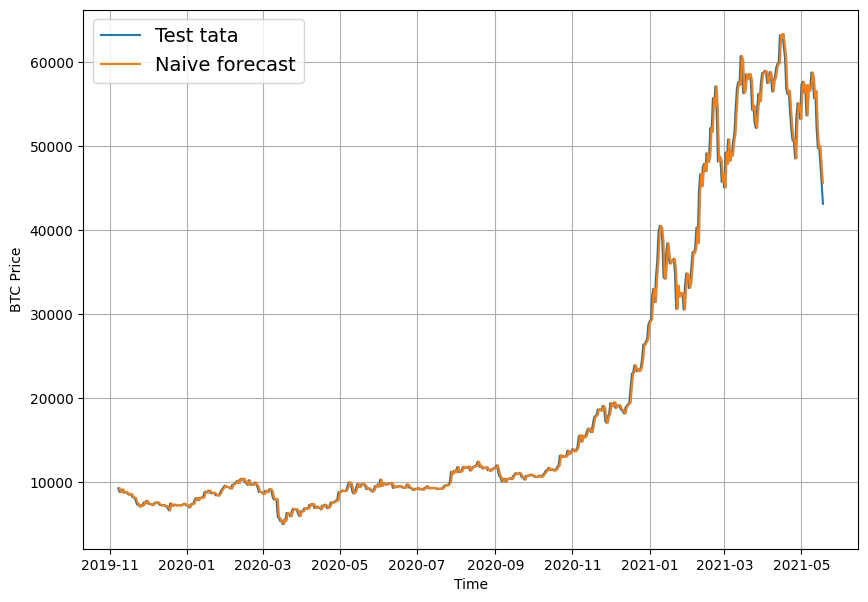

In [18]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(X_train, y_train, label="Train tata")
plot_time_series(X_test, y_test, format="-", label="Test tata")
plot_time_series(X_test[1:], naive_forecast, format="-", label="Naive forecast")

## Evaluating a time series model

Common regression metrics:
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root MSE, easier to interpret than MSE
* (s)MAPE - (symmetric) mean absolute percentage error (not advised)
* MASE - mean absolute scaled error - scaled by error of naive forecast

https://otexts.com/fpp3/accuracy.html

https://github.com/CamDavidsonPilon/Python-Numerics/blob/master/TimeSeries/MASE.py

In [19]:
import tensorflow as tf

In [20]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE, assuming no seasonality/seasonality of 1 day
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season


In [21]:
mean_absolute_scaled_error(y_test[1:], naive_forecast).numpy()

0.9995699939182624

In [22]:
# Multi-metric function for calculating prediction metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype for metric calculations in order for tf not to spew errors
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_true = tf.cast(y_true, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(), # so that it doesn't return tf tensors
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [23]:
naive_results = evaluate_preds(y_test[1:], naive_forecast)
naive_results

{'mae': 567.9802183723001,
 'mse': 1147547.0780835983,
 'rmse': 1071.2362382236695,
 'mape': 2.5165248502692306,
 'mase': 0.99957}

## Other models that can be used as baselines and actual forecasts

https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/?ref=mrdbourke.com#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format data part 2: Windowing the the dataset

So that the model predicts on 7 samples

https://www.uber.com/en-PL/blog/forecasting-introduction/

In [24]:
# Set up global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # based on last week

In [25]:
# Create fcn to label windowed data
def get_labelled_window(x, horizon=HORIZON):
  return x[:,:-horizon], x[:, -horizon:]

In [26]:
# Test out the window labelling fcn
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8), axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[7]], dtype=int32)>)

Instead of using for loops to convert our data into features and labels, we'll use numpy array indexing for speed

https://numpy.org/doc/stable/user/basics.indexing.html

https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [27]:
import numpy as np

#  Function to window the input data
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1 D array into a 2D arrayof sequential labelled windows of window_size with horizon size labels
  """
  # Create a window of specific size
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # Create a 2D array of multiple windows
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  # Use the above to index on the timeseries
  windowed_array = x[window_indexes]
  # Get labelled windows
  windows, labels = get_labelled_window(windowed_array, horizon)

  return windows, labels

# Much much faster than python for loops

In [28]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [29]:
# View first 3 windows w/ labels
for i in range(3):
  print(f"Window: {full_windows[i]}, label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ], label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ], label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ], label: [125.96116]


In [30]:
# View last 3 windows w/ labels
for i in range(3):
  print(f"Window: {full_windows[i-3]}, label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676], label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472], label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361], label: [43144.47129086]


Actually you can do all that with just the function `tf.keras.preprocessing.timeseries_dataset_from_array` https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

## Turning windows into training and test sets

In [31]:
# Make train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows)*(1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [32]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

## Make a modelling checkpoint callback

To compare each model's best performances


In [33]:
import os

# Create a fcn to implement a checkpoint callback
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model with window = 7 and horizon = 1

* Single dense layer with 128 neurons and ReLU
* Output layer with linear activation
* Adam optimizer and MAE loss fcn
* Batch size of 128
* 100 epochs

https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=pl

In [34]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for reproducibility
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense_7_1")

# Compile
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="mae",
                metrics=["mae","mse"])

# Fit
model_1.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 6s 164ms/step - loss: 2156.5786 - mae: 2156.5786 - mse: 13629203.0000 - val_loss: 1870.4869 - val_mae: 1870.4869 - val_mse: 8367095.0000
Epoch 2/100
18/18 [==============================] - 2s 110ms/step - loss: 363.6466 - mae: 363.6466 - mse: 508723.8125 - val_loss: 1699.0441 - val_mae: 1699.0441 - val_mse: 7099539.0000
Epoch 3/100
18/18 [==============================] - 1s 66ms/step - loss: 240.3683 - mae: 240.3683 - mse: 271675.9688 - val_loss: 1090.3877 - val_mae: 1090.3877 - val_mse: 3822947.2500
Epoch 4/100
18/18 [==============================] - 1s 79ms/step - loss: 197.7773 - mae: 197.7773 - mse: 197883.3125 - val_loss: 1049.2423 - val_mae: 1049.2423 - val_mse: 3684569.0000
Epoch 5/100
18/18 [==============================] - 0s 12ms/step - loss: 190.4286 - mae: 190.4286 - mse: 189269.9375 - val_loss: 1062.5825 - val_mae: 1062.5825 - val_mse: 3574072.7500
Epoch 6/100
18/18 [==============================] - 2s 88ms/step - l

In [35]:
# Evaluate model
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 621.5430 - mae: 621.5430 - mse: 1269586.0000


[621.54296875, 621.54296875, 1269586.0]

In [36]:
# Load in the saved best performing model
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_dense_7_1")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 566.9916 - mae: 566.9916 - mse: 1171993.1250


[566.9916381835938, 566.9916381835938, 1171993.125]

In [37]:
naive_results

{'mae': 567.9802183723001,
 'mse': 1147547.0780835983,
 'rmse': 1071.2362382236695,
 'mape': 2.5165248502692306,
 'mase': 0.99957}

## Making forecasts with the model

In [38]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [39]:
# Make predictions and view results
model_1_preds = make_preds(model_1, test_windows)
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds) # tensors of different shapes
model_1_results

18/18 [==============================] - 0s 2ms/step


{'mae': 566.9916,
 'mse': 1171993.0,
 'rmse': 1082.5863,
 'mape': 2.561862,
 'mase': 0.99604714}

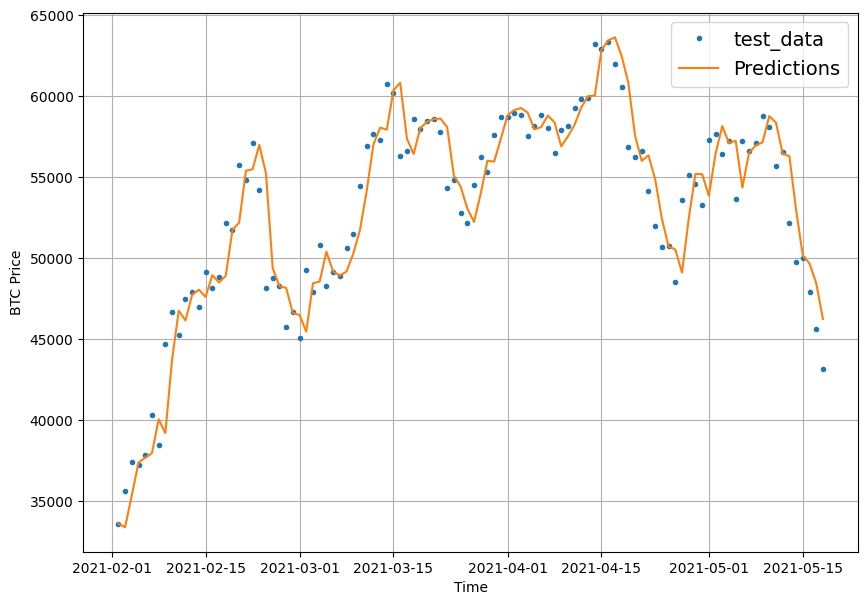

In [40]:
# Plot preds
offset = 450
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="Predictions")

https://otexts.com/fpp2/autocorrelation.html

## Model 2: Dense window = 30, horizon = 1

In [41]:
WINDOW_SIZE = 30

In [42]:
# Make window data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE) # otherwise it takes the WINDOW value specified before fcn definition
len(full_windows), len(full_labels)

(2757, 2757)

In [43]:
# Make train and test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

len(train_windows), len(test_windows)

(2205, 552)

In [44]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense_30_1")

# Compile
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="mae")

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [45]:
# Evaluate
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 674.0579


674.057861328125

In [46]:
# Load the best performig one
model_2 = tf.keras.models.load_model("/content/model_experiments/model_2_dense_30_1")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 613.3463


613.3463134765625

In [47]:
# Get forecast predictions
model_2_preds = make_preds(model_2, test_windows)
# Calculate resultd
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

18/18 [==============================] - 0s 2ms/step


{'mae': 613.3463,
 'mse': 1296627.0,
 'rmse': 1138.6953,
 'mape': 2.767736,
 'mase': 1.0721353}

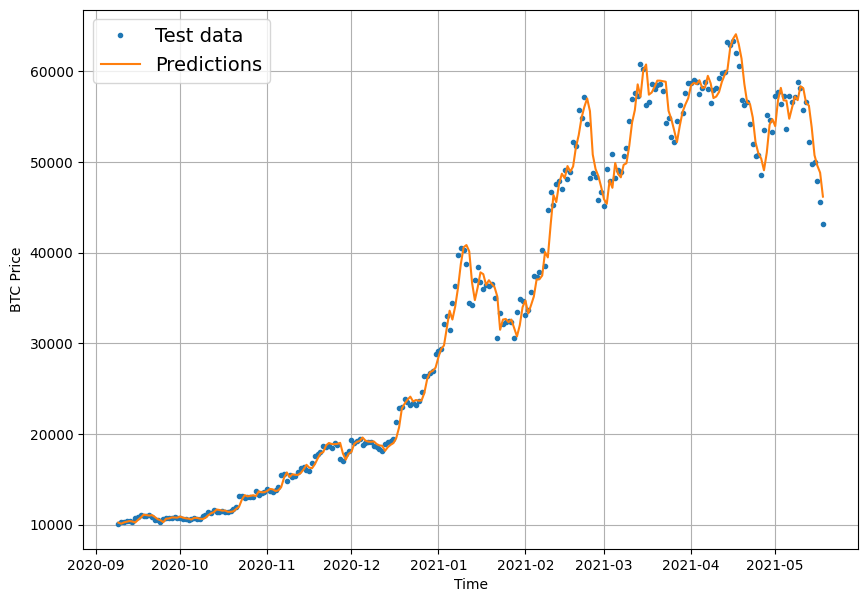

In [48]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(X_test[-len(test_windows):], test_labels[:,0], start=offset, label="Test data")
plot_time_series(X_test[-len(test_windows):], model_2_preds, start=offset, format="-", label="Predictions")

## Model 3: Dense window = 30 horizon = 7

In [49]:
WINDOW_SIZE = 30
HORIZON = 7

# Make window data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
# Make train and test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows)

(2200, 551)

In [50]:
tf.random.set_seed(42)

# Create model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_3_dense_30_7")

# Compile
model_3.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="mae")

# Fit
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [51]:
# Evaluate
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 1383.9088


1383.9088134765625

In [52]:
# Load the best performig one
model_3 = tf.keras.models.load_model("/content/model_experiments/model_3_dense_30_7")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 1s 8ms/step - loss: 1222.3210


1222.321044921875

In [53]:
# Get forecast predictions
model_3_preds = make_preds(model_3, test_windows)
# Calculate results
model_3_results = evaluate_preds(tf.squeeze(test_labels), model_3_preds[:,6])
model_3_results

18/18 [==============================] - 0s 10ms/step


InvalidArgumentError: ignored

## Make the evaluation fcn work for larger horizons

In [55]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype for metric calculations in order for tf not to spew errors
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_true = tf.cast(y_true, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(), # so that it doesn't return tf tensors
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [56]:
model_3_results = evaluate_preds(tf.squeeze(test_labels), model_3_preds)
model_3_results

{'mae': 1222.321,
 'mse': 5343279.5,
 'rmse': 1406.0939,
 'mape': 5.4511485,
 'mase': 2.1750515}

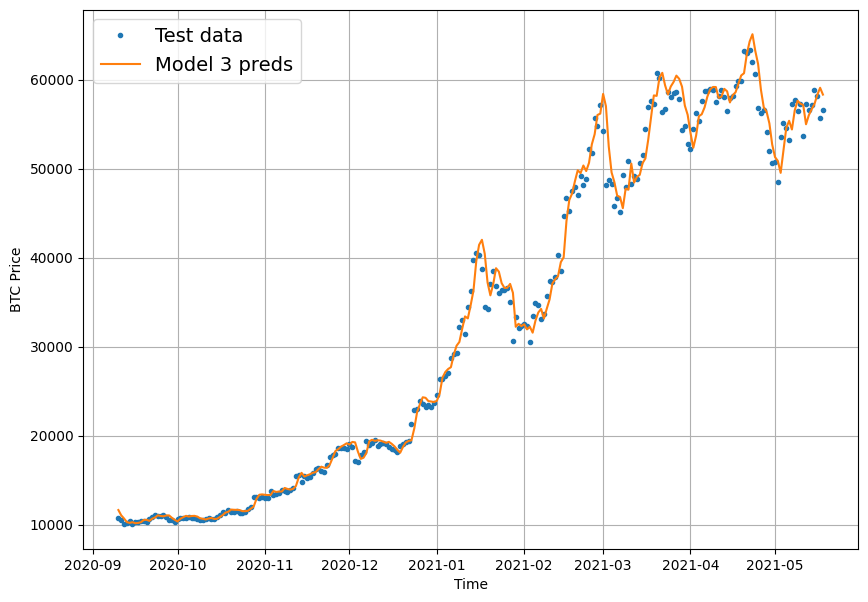

In [57]:
# Plot results
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(X_test[-len(test_windows):], test_labels[:,0], start=offset, label="Test data")
plot_time_series(X_test[-len(test_windows):], tf.reduce_mean(model_3_preds, axis=1), start=offset, label=f"Model 3 preds", format="-")

## Which of the models is performing best so far

https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

<Axes: >

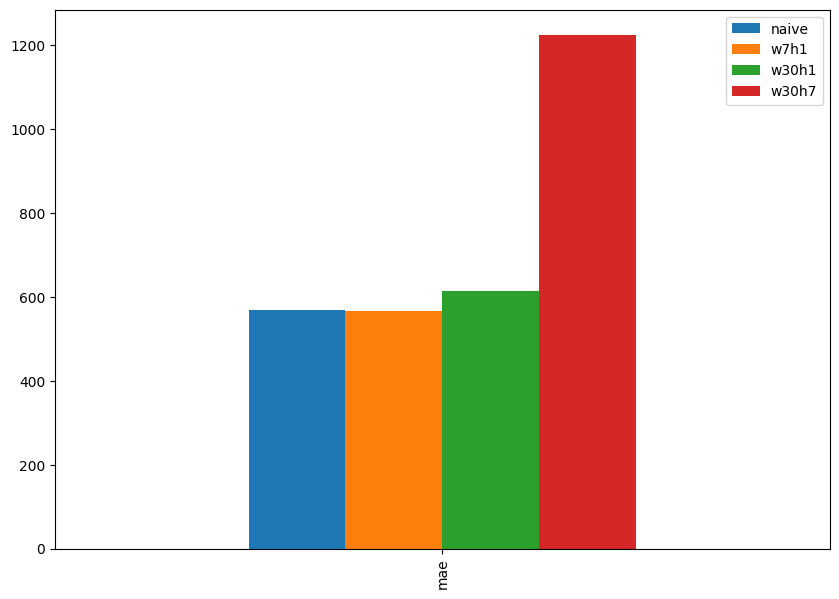

In [58]:
import pandas as pd
pd.DataFrame({"naive": naive_results["mae"],
              "w7h1": model_1_results["mae"],
              "w30h1": model_2_results["mae"],
              "w30h7": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar")

## Model 4: Conv1D

In [59]:
HORIZON = 1
WINDOW_SIZE = 7

In [60]:
# Create a window dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
# Make train and test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

TO use a Conv1D layer we need an input shape of `(batch_size, timesteps, input_dim)`

In [61]:
train_windows[0].shape

(7,)

In [62]:
# Reahape the data
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra layer

In [63]:
# Test the lambda layer
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")

Original shape: (7,)
Expanded shape: (7, 1)


In [64]:
tf.random.set_seed(42)

# Create a model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(128, kernel_size=WINDOW_SIZE, padding="causal", activation="relu"), # Padding specifically for temporal data
    layers.Dense(HORIZON)
], name="model_4_conv1d")

# Compile
model_4.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="mae")

# Fit
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [65]:
model_4.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            6400      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 6529 (25.50 KB)
Trainable params: 6529 (25.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 647.4673


647.4673461914062

In [67]:
model_4 = tf.keras.models.load_model("/content/model_experiments/model_4_conv1d")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 1s 9ms/step - loss: 572.1281


572.1281127929688

In [68]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds.shape

18/18 [==============================] - 0s 8ms/step


TensorShape([556])

In [69]:
# Evaluate
model_4_results = evaluate_preds(tf.squeeze(test_labels), model_4_preds)
model_4_results

{'mae': 572.12805,
 'mse': 1177384.4,
 'rmse': 1085.0735,
 'mape': 2.5656977,
 'mase': 1.0050706}

## Model 5: LSTM

In [70]:
tf.random.set_seed(42)

# Create a model the functional way
inputs = layers.Input(shape=WINDOW_SIZE)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # for LSTM layer
# x = layers.LSTM(128, return_sequences=True)(x) # return_sequences=True needed if the LSTMs are stacked
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5_LSTM")

# Compile
model_5.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="mae")

# Fit
model_5.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 11s 418ms/step - loss: 2280.1482 - val_loss: 9694.4873
Epoch 2/100
18/18 [==============================] - 5s 289ms/step - loss: 762.1394 - val_loss: 1153.4910
Epoch 3/100
18/18 [==============================] - 0s 13ms/step - loss: 252.6739 - val_loss: 1331.8823
Epoch 4/100
18/18 [==============================] - 3s 194ms/step - loss: 199.6686 - val_loss: 1052.1539
Epoch 5/100
18/18 [==============================] - 8s 469ms/step - loss: 185.9712 - val_loss: 1033.9644
Epoch 6/100
18/18 [==============================] - 5s 281ms/step - loss: 186.8048 - val_loss: 1023.7814
Epoch 7/100
18/18 [==============================] - 0s 17ms/step - loss: 182.9012 - val_loss: 1032.7992
Epoch 8/100
18/18 [==============================] - 0s 19ms/step - loss: 180.1352 - val_loss: 1030.3320
Epoch 9/100
18/18 [==============================] - 0s 21ms/step - loss: 178.0235 - val_loss: 1024.8998
Epoch 10/100
18/18 [============================

In [71]:
# Load in the best version of model 5 and evaluate
model_5 = tf.keras.models.load_model("/content/model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 585.5156


585.5155639648438

In [72]:
# make preds
model_5_preds = make_preds(model_5, test_windows)
model_5_preds.shape

18/18 [==============================] - 0s 3ms/step


TensorShape([556])

In [73]:
# Evaluate
model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_preds)
model_5_results

{'mae': 585.5156,
 'mse': 1231795.6,
 'rmse': 1109.8629,
 'mape': 2.6373308,
 'mase': 1.0285888}

## Make a multivariate time series

Add BTC halving events

https://www.cmcmarkets.com/en-nz/learn-cryptocurrencies/bitcoin-halving

In [74]:
# Let's add these to the dataset
block_reward_1 = 50 # 3 January 2009 - out of our dtaset
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25# 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [77]:
# Create date ranges of cpecific block_reward values
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [78]:
# Add in a block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days,-1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days,-1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:,-1] = block_reward_4

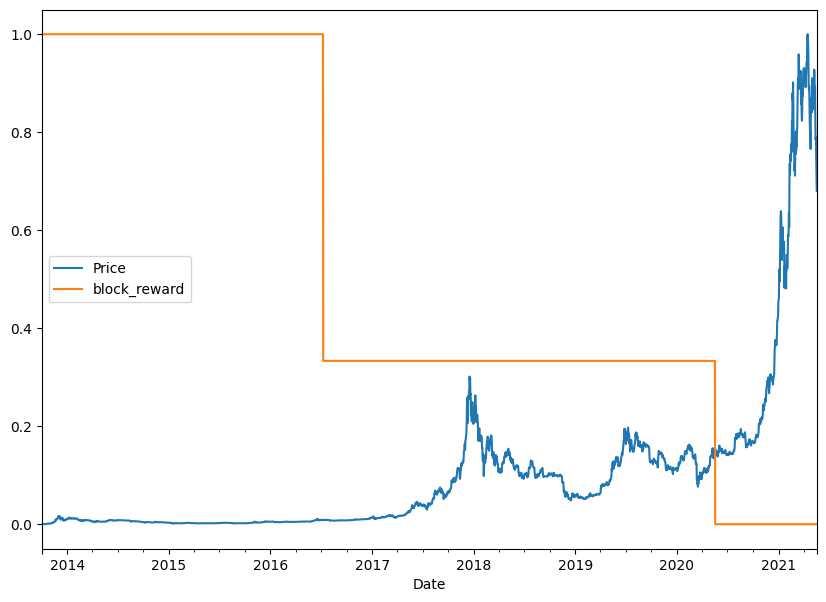

In [80]:
# Plot the block reward vs price overtime
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # cool huh?
                                                  columns=bitcoin_prices_block.columns,
                                                  index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pd
`pd.Dataframe.shift()`

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html

In [81]:
# Setup our dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [85]:
# Make a copy of BTC historical data
bitcoin_prices_windowed = bitcoin_prices.copy()
# Use shift method
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [87]:
# Create X - windows, y - horizons features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head(), y.head()

(               Price+1     Price+2     Price+3     Price+4     Price+5  \
 Date                                                                     
 2013-10-08  121.794998  120.655327  121.338661  118.674660  108.584831   
 2013-10-09  123.032997  121.794998  120.655327  121.338661  118.674660   
 2013-10-10  124.049004  123.032997  121.794998  120.655327  121.338661   
 2013-10-11  125.961159  124.049004  123.032997  121.794998  120.655327   
 2013-10-12  125.279663  125.961159  124.049004  123.032997  121.794998   
 
                Price+6     Price+7  
 Date                                
 2013-10-08  125.455002  123.654991  
 2013-10-09  108.584831  125.455002  
 2013-10-10  118.674660  108.584831  
 2013-10-11  121.338661  118.674660  
 2013-10-12  120.655327  121.338661  ,
 Date
 2013-10-08    123.032997
 2013-10-09    124.049004
 2013-10-10    125.961159
 2013-10-11    125.279663
 2013-10-12    125.927498
 Name: Price, dtype: float32)

In [88]:
# Make train and test sets
split_size = int(len(X)*0.8)
X_train, X_test, y_train, y_test = X[:split_size], X[split_size:], y[:split_size], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense, multivariate

In [90]:
tf.random.set_seed(42)

# Create the model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="mae")

# Fit
model_5.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [91]:
# Evaluate
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 17474.7539


17474.75390625

In [92]:
# Load in and evaluate the best performing model
model_6 = tf.keras.models.load_model("/content/model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 6ms/step - loss: 583.4946


583.4945678710938

In [93]:
# Make preds
model_6_preds = tf.squeeze(model_6.predict(X_test))

18/18 [==============================] - 0s 6ms/step


In [95]:
# Evaluate predictions
model_6_results = evaluate_preds(y_test, model_6_preds)
model_6_results

{'mae': 583.4946,
 'mse': 1214614.5,
 'rmse': 1102.0955,
 'mape': 2.6314068,
 'mase': 1.0250385}

As an excercise try improving the model
https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#model-6-dense-multivariate-time-series

## Model 7: N-BEATS

https://arxiv.org/abs/1905.10437

### Building and testing the N-BEATS block layer

https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing

In [96]:
class NBeatsBlock(tf.keras.layers.Layer): # inherits from Layer class
  def __init__(self, # constructor
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # keyword arguments takes care of all arguments for the parent class

    super().__init__(**kwargs) # makes an instance of the superclass

    self.input_size = input_size # define attributes
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of Dense layers with relu activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]

    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)

    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon]

    return backcast, forecast

Let's test the N-Beats class

In [97]:
# Set up dummy NBeatsBlock layer
tf.random.set_seed(42) # initializes with random weights
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [98]:
# Create dummy inputs
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0) # for appropriaqte input shape for a Dense layer
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [100]:
# Pass the inputs through the layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [0.5895909  0.08279766 0.18038066 0.08941906 0.5329423  0.10198046
 0.22477505]
Forecast: 0.49817872047424316


### Create tf data pipelines